# August
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

---

### import

In [1]:
# Import
import rpy2
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as pxa
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr
from plotly.subplots import make_subplots
import plotly.express as px

---

## Introduction

___

## Review

___

## Proposed Method

**Algorithm**
1. There are $x,y,z$ data on non-Euclidean space
    - Simulstion
        - Euclidean, Non-Euclidean space
    - Real data
        - Non-Euclidean space
2. $w$ is a weight matrix between nodes,
    - Simulation
        - Define as the same distance 
    - Real data
        - Compute distance using Haversine theory
        - Compute weight matrix: $$W_{i,j}=\begin{cases}{exp(-\{{\frac{dist(i,j)}{\theta}\}^2})} & \quad \text{,if } dist(i,j) \leq \kappa \\ 0 & \quad \text{,otherwise} \end{cases}$$
            - Note: $\theta$, $\kappa$ = hyper parameter
3. Graph Laplacian
    - $L = D^{-\frac{1}{2}}(D-W)D^{-\frac{1}{2}}$
        - Note: $D = \sum_{ij}W_{ij}$
4. Eigen Decomposition of Laplacian Matrix
    - $\Psi^\top L = \Lambda \Psi^\top$
        - Note: $\Psi^\top = \Psi^{-1}$
        - Note: $\Psi\Psi^\top = I$
    - $L = \Psi^\top L \Psi = \Psi \Lambda \Psi^\top = \Lambda$
5. Graph Fourier Transform 
    - $\bar{f} = \Psi^\top f$
6. Fourier Power 
    - Definition of Fourier Power Spectrum : Squared value of the signal 
        - Therefore, power = $\bar{f}^2$
7. Ebayesthresh
    - Standard Deviation
        - Simulation
            - The SD is 5
        - Real Data
            - The SD is defined automatically
    - Overview of the method
        - power$\downarrow$ $\to$ powerthresh = zero
        - power$\uparrow$ $\to$ powerthresh = nonzero
        - $\bar{f}_{threshed} = \begin{cases}{\bar{f}} & \quad {\text{power thresh} > 0} \\ {0} & \quad {\text{power thresh} < 0} \end{cases}$
8. Inverse Graph Fourier Transform
    - $\hat{f} = \Psi \bar{f}_{threshed}$
9. Residual Square
    - Residual = $f - \hat{f}$
        - Define large scale of Residual as Outlier
    - Standard
        - AIC, etc.

___

## Simulation Study

on Euclidean space (1)

$$y = 5x + \epsilon$$

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [4]:
%R -o x 

In [5]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

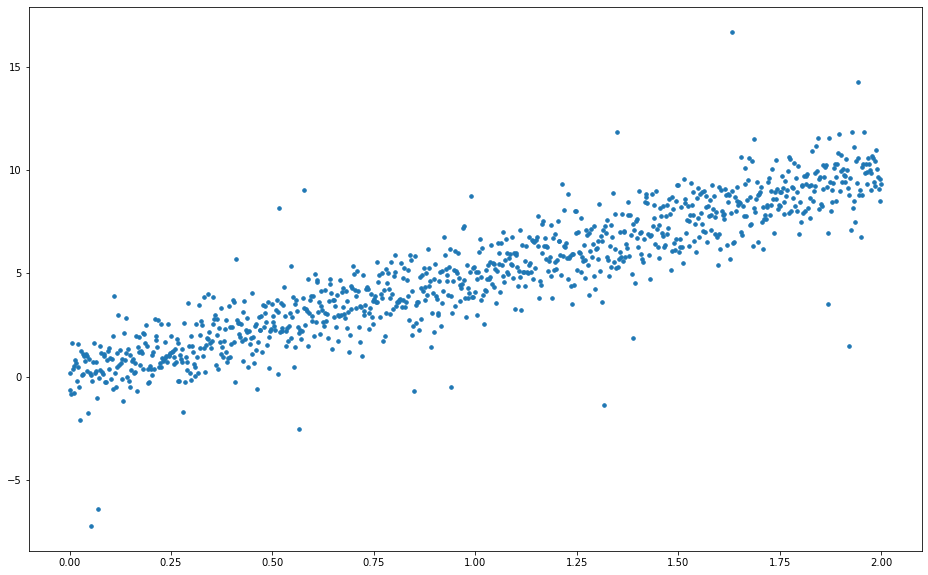

In [6]:
p=plt.figure(figsize=(16,10))
ax=p.add_subplot(1,1,1)
ax.scatter(_x,_y,s=50,marker='.')

In [7]:
df1=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [8]:
w=np.zeros((1000,1000))

In [9]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [10]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        self.differ=(np.abs(self.y-self.yhat)-np.min(np.abs(self.y-self.yhat)))/(np.max(np.abs(self.y-self.yhat))-np.min(np.abs(self.y-self.yhat))) #color 표현은 위핸 표준화
        self.df = self.df.assign(differ = self.differ)
        #with plt.style.context('seaborn-dark'):
            #plt.figure(figsize=(16,10))
            #plt.scatter(self.x,self.y,c=self.differ3,cmap='Purples',s=50)
            #plt.plot(self.x,self.yhat, 'k--')
        
    def vis(self,ref=60):
        fig = go.Figure()
        fig.add_scatter(x=self.x,y=self.y,mode="markers",marker=dict(size=3, color="#9fc5e8"),name='y',opacity=0.7)
        fig.add_scatter(x=self.x,y=self.yhat,mode="markers",marker=dict(size=3, color="#000000"),name='yhat',opacity=0.7)
        fig.add_scatter(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'],mode="markers",marker=dict(size=3, color="#f20505"),name='R square',opacity=1)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#0000FF',name='underline'))
        fig.update_layout(width=1000,height=1000,autosize=False,margin={"r":0,"t":0,"l":0,"b":0})
        #fig.show(config = dict({'scrollZoom': False}))
        #위로 변경 후 slide
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def sub(self):
        fig, axs = plt.subplots(2,2,figsize=(16,10))

        axs[0,0].plot(self.power)
        axs[0,0].plot(self.power_threshed)
        axs[0,0].set_title('power_threshed')

        axs[0,1].plot(self.power[1:])
        axs[0,1].plot(self.power_threshed[1:])
        axs[0,1].set_title('power_threshed 1:')

        axs[1,0].plot(self.power[2:])
        axs[1,0].plot(self.power_threshed[2:])
        axs[1,0].set_title('power_threshed 2:')

        axs[1,1].plot((self.df.Residual)**2)
        axs[1,1].set_title('Residual square')

        plt.tight_layout()
        plt.show()
    def subvis(self,ref=60):
        fig = make_subplots(rows=2, cols=2, subplot_titles=("y", "yhat", "Residual Square", "Graph"))
                            
        fig.add_scatter(x=self.x,y=self.y, mode="markers",marker=dict(size=3, color="#9fc5e8"),name='y',opacity=0.7,row=1,col=1)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#000000',name='underline'),row=1,col=1)
        
        fig.add_scatter(x=self.x,y=self.yhat, mode="markers",marker=dict(size=3, color="#999999"),name='yhat',opacity=0.7,row=1,col=2)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#000000',name='underline'),row=1,col=2)
        
        fig.add_scatter(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'], mode="markers",marker=dict(size=3, color="#f20505"),name='R square',opacity=1,row=2,col=1)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#000000',name='underline'),row=2,col=1)
        
        fig.add_scatter(x=self.x,y=self.y, mode="markers",marker=dict(size=3, color="#9fc5e8"),name='y',opacity=0.7,row=2,col=2)        
        fig.add_scatter(x=self.x,y=self.yhat, mode="markers",marker=dict(size=3, color="#999999"),name='yhat',opacity=0.7,row=2,col=2)        
        fig.add_scatter(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'], mode="markers",marker=dict(size=3, color="#f20505"),name='R square',opacity=1,row=2,col=2)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#000000',name='underline'),row=2,col=2)
        
        fig.update_xaxes(range=[0, 2], row=1, col=1)
        fig.update_yaxes(range=[-5, 15], row=1, col=1)
        
        fig.update_xaxes(range=[0, 2], row=1, col=2)
        fig.update_yaxes(range=[-5, 15], row=1, col=2)
        
        fig.update_xaxes(range=[0, 2], row=2, col=1)
        fig.update_yaxes(range=[-5, 15], row=2, col=1)
        
        fig.update_xaxes(range=[0, 2], row=2, col=2)
        fig.update_yaxes(range=[-5, 15], row=2, col=2)
        
        fig.update_layout(width=1000,height=1000,autosize=False,showlegend=False,title_text="The result")
        #fig.show(config = dict({'scrollZoom': False}))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [11]:
class SIMUL2(SIMUL):
    def fit2(self,sd=5,ref=60,cuts=0,cutf=995):
        self.fit()
        with plt.style.context('seaborn-dark'):
            plt.figure(figsize=(16,10))
            plt.scatter(self.x,self.y,c=self.differ3,cmap='Purples',s=50)
            plt.scatter(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],color='red',s=50)
            plt.plot(self.x,self.y1,'b--')
            plt.plot(self.x[cuts:cutf],self.yhat[cuts:cutf], 'k--')
    def fit3(self,sd=5,ref=30,ymin=-5,ymax=20,cuts=0,cutf=995):
        self.fit()
        with plt.style.context('seaborn-dark'):
            fig, axs = plt.subplots(2,2,figsize=(16,10))

            axs[0,0].scatter(self.x,self.y,c=self.differ,cmap='Purples',s=50)
            axs[0,0].set_title('y')
            axs[0,0].set_ylim([ymin,ymax])
            

            axs[0,1].plot(self.x[cuts:cutf],self.yhat[cuts:cutf], 'k')
            axs[0,1].plot(self.x[cuts:cutf],self.y1[cuts:cutf], 'b',alpha=0.5)
            axs[0,1].set_title('yhat')
            axs[0,1].set_ylim([ymin,ymax])

            axs[1,0].scatter(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],color='red',s=50,marker='*')
            axs[1,0].plot(self.x[cuts:cutf],self.y1[cuts:cutf], 'b',alpha=0.5)
            axs[1,0].set_title('Residual square')
            axs[1,0].set_ylim([ymin,ymax])

            axs[1,1].scatter(self.x,self.y,c=self.differ,cmap='Purples',s=50)
            axs[1,1].plot(self.x[cuts:cutf],self.yhat[cuts:cutf], 'k')
            axs[1,1].scatter(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],color='red',s=50,marker='*')
            axs[1,1].set_title('Graph')
            axs[1,1].set_ylim([ymin,ymax])

            plt.tight_layout()
            plt.show()

In [12]:
_simul = SIMUL2(df1)

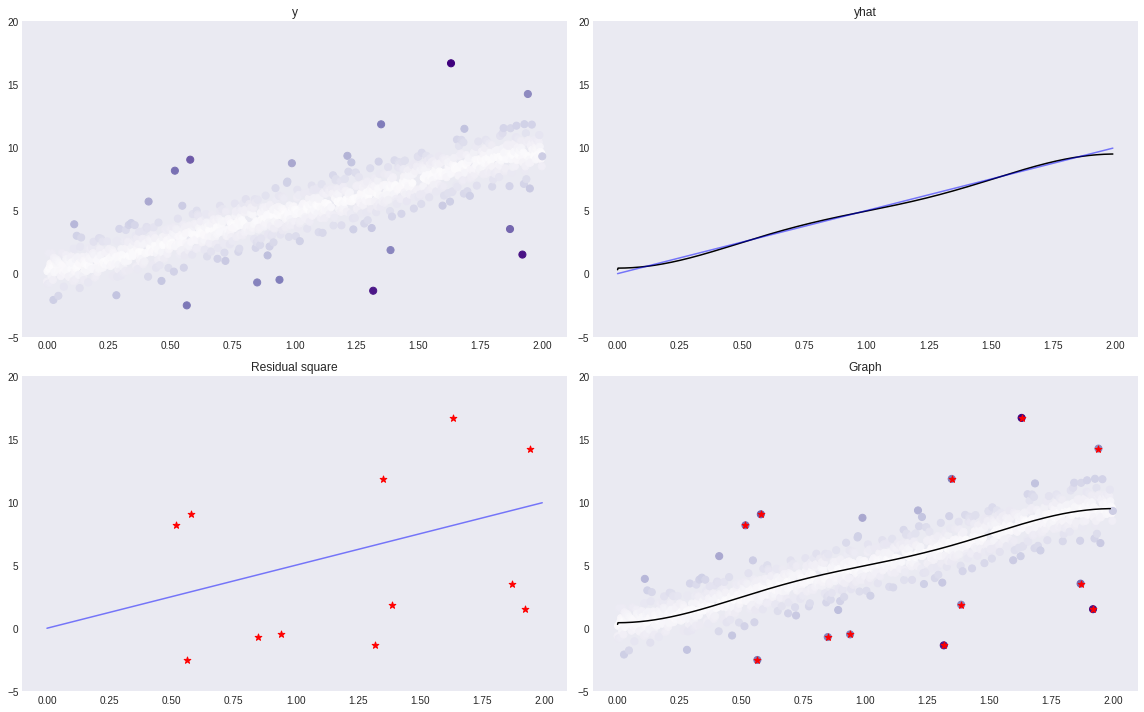

In [13]:
_simul.fit3(sd=5,ref=20,ymin=-5,ymax=20)

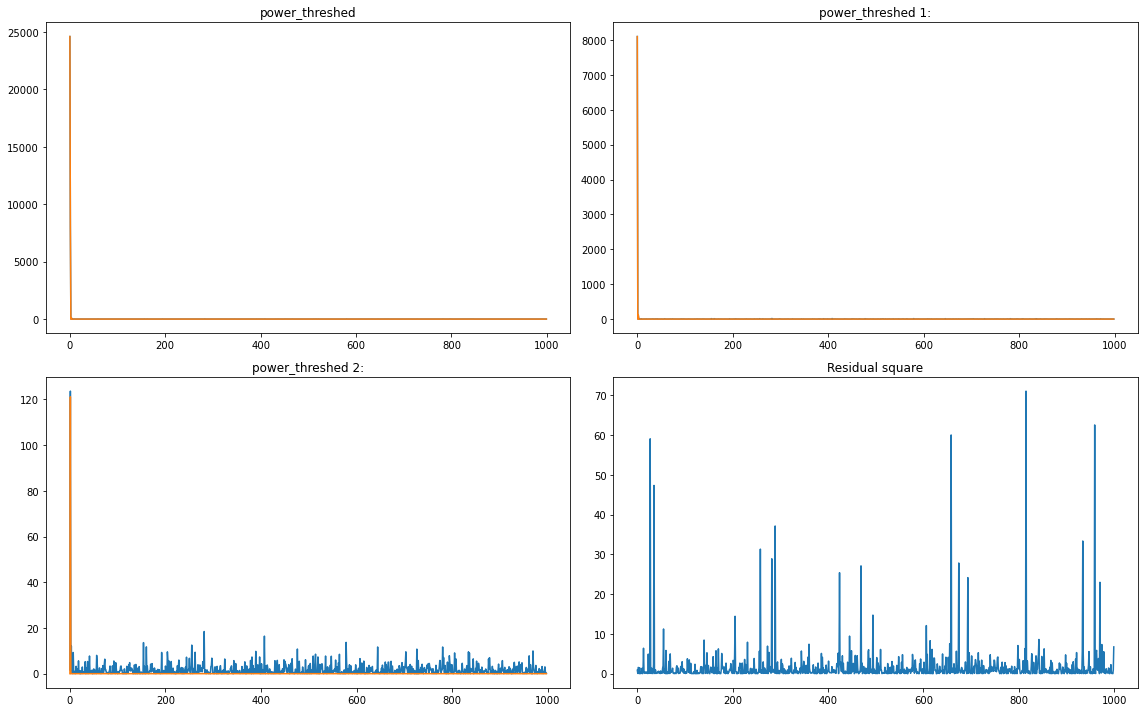

In [14]:
_simul.sub()

On Euclidean Space (2)

$$y = 5\sin(x) + \epsilon$$

In [15]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

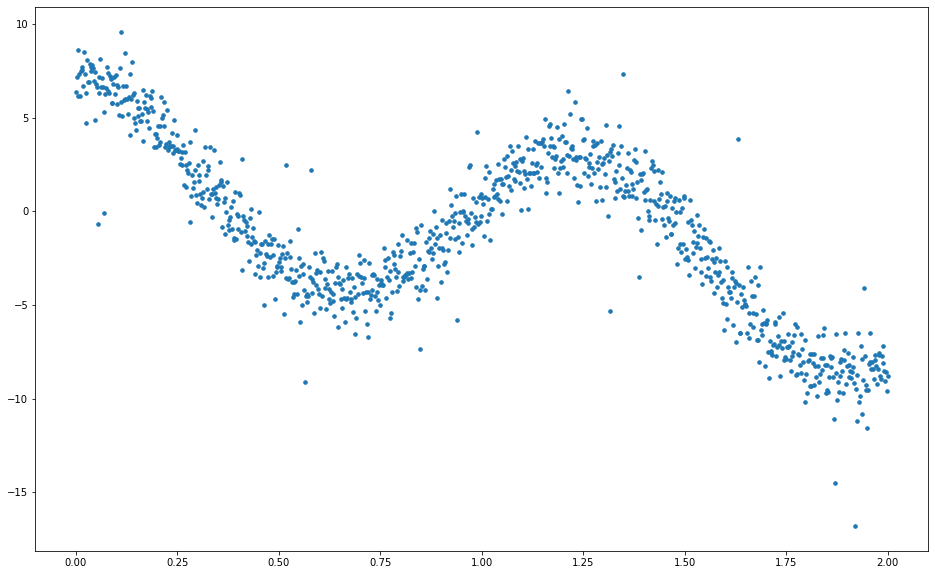

In [16]:
p=plt.figure(figsize=(16,10))
ax=p.add_subplot(1,1,1)
ax.scatter(_x,_y,s=50,marker='.')

In [17]:
df4=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [18]:
_simul = SIMUL2(df4)

In [47]:
_simul.fit3(ymin=-15,ymax=15)

AttributeError: 'SIMUL' object has no attribute 'fit3'

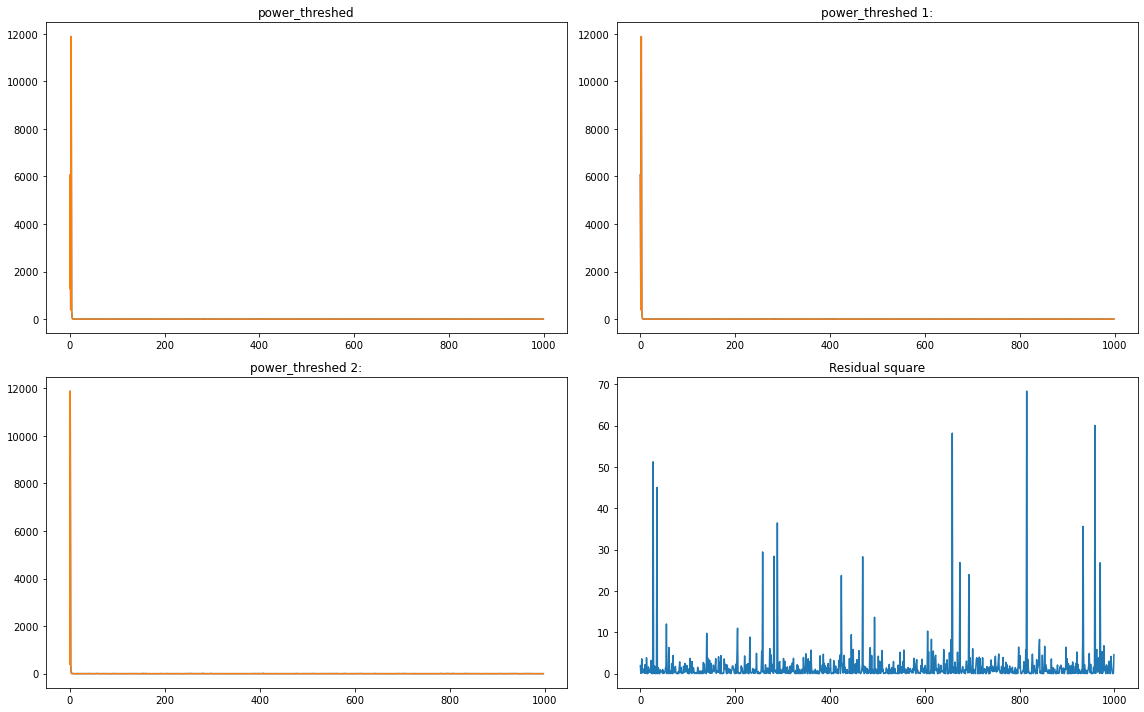

In [20]:
_simul.sub()

On Non-Euclidean Space

- $Angle = [-\pi , \pi-2\times\frac{\pi}{n}]$
- $r = 2 \times \sin{[0,6\pi]}$
- $x = r \times \cos{(angle)} $
- $y = r \times \sin{(angle)} $
- $f = 10 \times \sin{[0,3\pi]} + \epsilon$

In [21]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

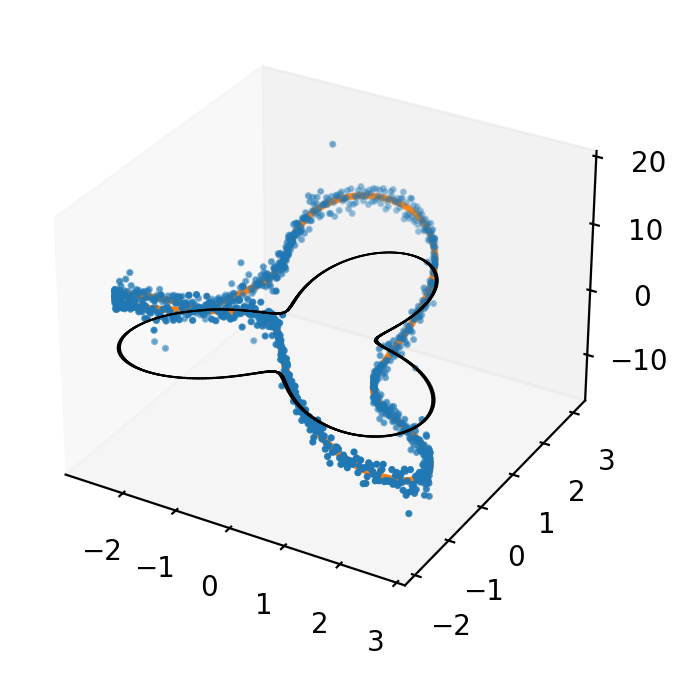

In [22]:
# 1. 
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
# 2. 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.')
ax.scatter3D(vx,vy,f1,zdir='z',s=10,marker='.')
ax.bar3d(vx, vy, np.zeros_like(f), 0.05, 0.05, 0, color='Black',shade=False)

In [23]:
df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f, 'f1' : f1})

In [24]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.f1 = df.f1.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=40): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.dif=(np.abs(self.f-self.fhat)-np.min(np.abs(self.f-self.fhat)))/(np.max(np.abs(self.f-self.fhat))-np.min(np.abs(self.f-self.fhat)))
        self.df = self.df.assign(dif = self.dif)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05
        
#         fig, axs = plt.subplots(2,2,figsize=(16,16),subplot_kw={"projection":"3d"})
#         axs[0,0].grid(False)
#         axs[0,0].scatter3D(self.x,self.y,self.f,c=self.dif,cmap='winter',zdir='z',s=50,marker='.',alpha=0.2)
#         axs[0,0].plot3D(self.x,self.y,[0]*1000,'black')
#         axs[0,0].set_xlim(-3,3)
#         axs[0,0].set_ylim(-3,3)
#         axs[0,0].set_zlim(-10,10)
        
#         axs[0,1].grid(False)
#         axs[0,1].scatter3D(self.x,self.y,self.fhat,color='black',zdir='z',s=50,marker='.',alpha=0.2)
#         axs[0,1].plot3D(self.x,self.y,self.f1,'blue')
#         axs[0,1].plot3D(self.x,self.y,[0]*1000,'black')
#         axs[0,1].set_xlim(-3,3)
#         axs[0,1].set_ylim(-3,3)
#         axs[0,1].set_zlim(-10,10)
        
#         axs[1,0].grid(False)
#         axs[1,0].scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['f'],color='red',zdir='z',s=100,marker='.',alpha=1)
#         axs[1,0].plot3D(self.x,self.y,self.f1,'blue')
#         axs[1,0].plot3D(self.x,self.y,[0]*1000,'black')
#         axs[1,0].set_xlim(-3,3)
#         axs[1,0].set_ylim(-3,3)
#         axs[1,0].set_zlim(-10,10)
        
#         axs[1,1].grid(False)
#         axs[1,1].scatter3D(self.x,self.y,self.f,c=self.dif,cmap='winter',zdir='z',s=50,marker='.',alpha=0.2)
#         axs[1,1].scatter3D(self.x,self.y,self.fhat,color='black',zdir='z',s=50,marker='.',alpha=0.2)
#         axs[1,1].scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['f'],color='red',zdir='z',s=100,marker='.',alpha=1)
#         axs[1,1].plot3D(self.x,self.y,self.f1,'black')
#         axs[1,1].plot3D(self.x,self.y,[0]*1000,'black')
#         axs[1,1].set_xlim(-3,3)
#         axs[1,1].set_ylim(-3,3)
#         axs[1,1].set_zlim(-10,10)
        
#         plt.tight_layout()
#         plt.show()
    def visf(self,ref=40):
        fig = go.Figure()
        fig.add_scatter3d(x=self.x,y=self.y,z=self.f, mode="markers",marker=dict(size=2, color="#9fc5e8"),name='f',opacity=0.6)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.f1,mode='lines',line_color='#000000',name='underline'))
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
        fig.update_layout(scene = dict(xaxis = dict(range=[-3,3],),
                                         yaxis = dict(range=[-3,3],),
                                         zaxis = dict(range=[-10,10],),),
                                      width=1000,height=1000,autosize=False)
        #fig.show(config = dict({'scrollZoom': False}))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visfhat(self,ref=40):
        fig = go.Figure()
        fig.add_scatter3d(x=self.x,y=self.y,z=self.fhat, mode="markers",marker=dict(size=2, color="#999999"),name='fhat',opacity=0.6)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.f1,mode='lines',line_color='#000000',name='underline'))
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
        fig.update_layout(scene = dict(xaxis = dict(range=[-3,3],),
                                         yaxis = dict(range=[-3,3],),
                                         zaxis = dict(range=[-10,10],),),
                                      width=1000,height=1000,autosize=False)
        #fig.show(config = dict({'scrollZoom': False}))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visres(self,ref=40):
        fig = go.Figure()
        fig.add_scatter3d(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'],z=self.df.query('Residual**2>@ref')['f'], mode="markers",marker=dict(size=2, color="#f20505"),name='R square',opacity=1)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.f1,mode='lines',line_color='#000000',name='underline'))
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
        fig.update_layout(scene = dict(xaxis = dict(range=[-3,3],),
                                         yaxis = dict(range=[-3,3],),
                                         zaxis = dict(range=[-10,10],),),
                                      width=1000,height=1000,autosize=False)
        f#ig.show(config = dict({'scrollZoom': False}))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def vis(self,ref=40):
        fig = go.Figure()
        fig.add_scatter3d(x=self.x,y=self.y,z=self.f, mode="markers",marker=dict(size=2, color="#9fc5e8"),name='f',opacity=0.6)
        fig.add_scatter3d(x=self.x,y=self.y,z=self.fhat, mode="markers",marker=dict(size=2, color="#999999"),name='fhat',opacity=0.6)
        fig.add_scatter3d(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'],z=self.df.query('Residual**2>@ref')['f'], mode="markers",marker=dict(size=2, color="#f20505"),name='R square',opacity=1)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.f1,mode='lines',line_color='#000000',name='underline'))
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
        fig.update_layout(scene = dict(xaxis = dict(range=[-3,3],),
                                         yaxis = dict(range=[-3,3],),
                                         zaxis = dict(range=[-10,10],),),
                                      width=1000,height=1000,autosize=False)
        #fig.show(config = dict({'scrollZoom': False}))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def sub(self):
        fig, axs = plt.subplots(2,2,figsize=(16,10))

        axs[0,0].plot(_simul.power)
        axs[0,0].plot(_simul.power_threshed)
        axs[0,0].set_title('power_threshed')

        axs[0,1].plot(_simul.power[1:])
        axs[0,1].plot(_simul.power_threshed[1:])
        axs[0,1].set_title('power_threshed 1:')

        axs[1,0].plot(_simul.power[2:])
        axs[1,0].plot(_simul.power_threshed[2:])
        axs[1,0].set_title('power_threshed 2:')

        axs[1,1].plot((_simul.df.Residual)**2)
        axs[1,1].set_title('Residual square')

        plt.tight_layout()
        plt.show()

In [25]:
_simul = SIMUL(df)

In [26]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 549.50it/s]


In [27]:
_simul.D[_simul.D>0].mean()

2.6888234729389295

In [28]:
_simul.get_weightmatrix(theta=(2.6888234729389295),kappa=2500) 

In [29]:
_simul.fit()

In [30]:
#_simul.visf()

In [31]:
#_simul.visfhat()

In [32]:
#_simul.visres()

In [33]:
#_simul.vis()

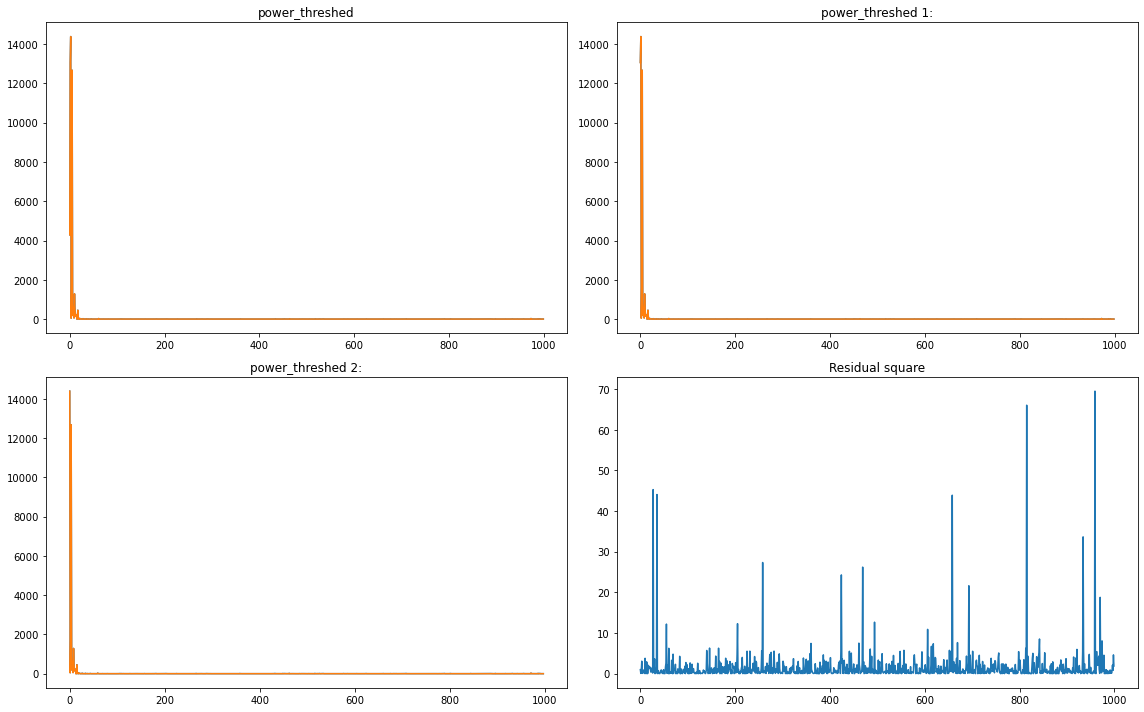

In [34]:
_simul.sub()

Bunny simulation?

___

## Real Data Analysis

- $x$ : Latitude
- $y$ : Longitude
- $f$ : Magnitude
- Period of Data : 2010 ~ 2014

In [35]:
df_global= pd.concat([pd.read_csv('00_05.csv'),pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv'),pd.read_csv('15_20.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

In [36]:
df_global = df_global.assign(Year=list(map(lambda x: x.split('-')[0], df_global.time))).iloc[:,1:]
df_global.Year = df_global.Year.astype(np.float64)

In [48]:
class realdata:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')
        
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=10,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 0.6
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.5
                      )
        #fig.show()
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visf(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=10,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        #fig.show(config = dict({'scrollZoom': False}))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visfhat(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='MagnitudeHat', 
                        radius=10,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        #fig.show(config = dict({'scrollZoom': False}))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visres(self,MagThresh=7,ResThresh=0.5):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z=[0] * len(self.df), 
                        radius=10,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.6
                      )
        #fig.show(config = dict({'scrollZoom': False}))
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [49]:
class realdata2(realdata): # ebayesthresh 기능추가
    def fit2(self,ref=0.5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2)))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        self.con = np.where(self.df.Residual>0.7,1,0)
        #plt.plot(self.f,'.')
        #plt.plot(self.fhat,'x')
#         fig, axs = plt.subplots(2,2,figsize=(16,10))

#         axs[0,0].plot(self.f,'b')
#         axs[0,0].set_title('Magnitude')
#         axs[0,0].set_ylim([4.5,9])

#         axs[0,1].plot(self.fhat,'k')
#         axs[0,1].set_title('MagnitudeHat')
#         axs[0,1].set_ylim([4.5,9])

#         axs[1,0].plot(self.con,'r*')
#         axs[1,0].set_title('Residual square')

#         axs[1,1].plot(self.f,'b')
#         axs[1,1].plot(self.fhat,'k')
#         axs[1,1].plot(self.con,'r*')
#         axs[1,1].set_title('Graph')
#         axs[1,1].set_ylim([4.5,9])

#         plt.tight_layout()
#         plt.show()

In [50]:
_global=realdata2(df_global.query("2010 <= Year < 2015"))

In [51]:
_global.get_distance()

100%|██████████| 12498/12498 [03:55<00:00, 53.00it/s] 


In [52]:
_global.get_weightmatrix(theta=(8810.865423093777),kappa=2500) 

In [53]:
_global.fit2()

In [54]:
#_global.visf()

In [55]:
#_global.visfhat()

In [56]:
#_global.visres()

In [46]:
#_global.vis(MagThresh=6.9,ResThresh=0.5)

**Note**

- Period : 2010 ~ 2015

- Ouest Department, Haiti, 2010y Magnitude 7.0
    - Residual = 0.711974
- Puchuncavi, Valparaíso, Chile, 2014y Magnitude 6.4
    - Residual = 0.694447
- Baoxing County, Yaan, Sichuan, China, 2013y Magnitude 6.6
    - Residual = 0.677169